<a href="https://colab.research.google.com/github/RobSpiewakowski/nauka-data-science/blob/main/M%C3%B3j_pierwszy_projekt_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt końcowy:

W ramach projektu ML chcemy przewidzieć ceny ofert wycieczek zamieszczonych na portalu wakacje.pl na podstawie zadanych kryteriów:

* Kraj - Turcja
* Czas trwania - 7 dni

Średni błąd predykcji nie powiniej przekraczać 500 zł / os.

Jak będziemy mierzyć spełnienie celu - metryki sukcesu:

MSE - błąd średniokwadratowy:
MSE = 1/N * SUMA(yi - średnia yi)^2

pierwiastek błędu średnniokwadratowego
Miara pozwala określić, w jakim stopniu model myli się w przewidywaniach.

In [1]:
# Import bibliotek:
import requests
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn import pipeline
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from urllib.parse import urljoin
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



Jakie informacje są dostępne w wyszukiwarce:

* Region i miejscowość,
* Liczba gwiazdek,
* Termin wyjazdu i powrotu,
* Miejsce wylotu,
* Rodzaj wyżywienia,
* Nazwa biura podróży,
* Ocena,
* Link do oferty.

# 1. Pobieranie danych ze źródła - scraping:

Wakacje.pl ogranicza wyniki wyszukiwania do 100 stron, więc jest to maksymalna liczba stron do zwscrapowania.

In [2]:
# Utworzenie żądania get():

# Prefiks linku, numer strony będzie zmieniał się w peli:
URL0 = 'https://www.wakacje.pl/wczasy/turcja/?str-'

oferty0 = []

#for i in range(1, 3):   # Do testów
for i in range(1, 101):
  time.sleep(1)

  URL = URL0 + str(i) + ',7-dni'                          # Utworzenie linku
  zwrotna_odpowiedź = requests.get(URL)                   # Request
  print('Strona ', i, '| Status: ', zwrotna_odpowiedź)    # Wtświetl status odpowiedzi
  html = zwrotna_odpowiedź.content                        # Zawartość strony
  zupa = BeautifulSoup(html, 'lxml')                      # Gotowanie zupy (parsowanie)

  # Oferty ze sescrapowanej strony:
  x0 = str(zupa.find_all('script')[4]).split('{"data":')[1].split(',"searchObj"')[0].split('},{')
  oferty0.append(x0)
  
  # Pętla, która wyciągnie wszystkie elementy z podlist listy oferty_surowe i umieści je w nowej liście:
oferty = []
for i in range(len(oferty0)):
  lista_pomocnicza = oferty0[i]
  for j in range(len(lista_pomocnicza)):
    a = lista_pomocnicza[j].split('"offerHash"')[0]
    oferty.append(a)

print(len(oferty))
print(oferty)

Strona  1 | Status:  <Response [200]>
Strona  2 | Status:  <Response [200]>
Strona  3 | Status:  <Response [200]>
Strona  4 | Status:  <Response [200]>
Strona  5 | Status:  <Response [200]>
Strona  6 | Status:  <Response [200]>
Strona  7 | Status:  <Response [200]>
Strona  8 | Status:  <Response [200]>
Strona  9 | Status:  <Response [200]>
Strona  10 | Status:  <Response [200]>
Strona  11 | Status:  <Response [200]>
Strona  12 | Status:  <Response [200]>
Strona  13 | Status:  <Response [200]>
Strona  14 | Status:  <Response [200]>
Strona  15 | Status:  <Response [200]>
Strona  16 | Status:  <Response [200]>
Strona  17 | Status:  <Response [200]>
Strona  18 | Status:  <Response [200]>
Strona  19 | Status:  <Response [200]>
Strona  20 | Status:  <Response [200]>
Strona  21 | Status:  <Response [200]>
Strona  22 | Status:  <Response [200]>
Strona  23 | Status:  <Response [200]>
Strona  24 | Status:  <Response [200]>
Strona  25 | Status:  <Response [200]>
Strona  26 | Status:  <Response [2

1. Pobieranie danych z ofert:

In [3]:
# Nazwa oferty:
nazwa_oferty = [oferty[i].split('"name":')[1].split('"placeName"')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Miejsce oferty:
miejsce_oferty = [oferty[i].split('"placeName":')[1].split('"link":')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Z miejsca wydłubiemy kraj i region:
kraj_oferty = [miejsce_oferty[j].split(' /')[0] for j in range(len(miejsce_oferty))]
region_oferty = []
for j in range(len(miejsce_oferty)):
  if '/' in miejsce_oferty[j]:
    a = miejsce_oferty[j].split(' /')[1]
  else:
    a = 'BRAK'
  region_oferty.append(a)

# Link do oferty:
# Prefiks linku do strony z oertami wczasów:
URL1 = 'https://www.wakacje.pl/oferty'

k = [oferty[i].split('"link":')[1].split(',"photo"')[0].strip('"') for i in range(len(oferty))]
link_oferty = [urljoin(URL1, k) for k in k]

# Kategoria hotelu:
kategoria_hotelu = [float(oferty[i].split('"category":')[1].split(',"maxCategory"')[0]) for i in range(len(oferty))]

# Czas trwania wczasów:
czas_trwania  =[oferty[i].split('"duration":')[1].split(',"durationNights"')[0] + ' dni' for i in range(len(oferty))]

# Termin wyjazdu:
termin_wyjazdu = [dt.datetime.strptime(oferty[i].split('"departureDate":')[1].split('"returnDate')[0].lstrip('"').rstrip('",'), "%Y-%m-%d").strftime("%d.%m.%Y") for i in range(len(oferty))]

# Za ile dni od dziś:

# Rodzaj dpjazdu:
dojazd_oferta = [oferty[i].split('"departureTypeName":')[1].split('"departurePlaces"')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Miejsce zbiórki:
zbiórka_oferta = [oferty[i].split('"departurePlace":')[1].split(',"returnDestinationPlace"')[0].lstrip('"').rstrip('"') for i in range(len(oferty))]

# Standard wyżywienia:
wyżywienie_oferta = [oferty[i].split('"serviceDesc":"')[1].split('","tourOperator')[0] for i in range(len(oferty))]

# Cena oferty:
cena_oferta = [float(oferty[i].split('"price":')[1].split(',"priceDiscount"')[0]) for i in range(len(oferty))]

# Nazwa biura podróży:
biuro_podróży = [oferty[i].split('"tourOperatorName":"')[1].split(',"ratingString')[0].rstrip('"') for i in range(len(oferty))]

# Ocena:
ocena_oferta = [float(oferty[i].split('"ratingValue":')[1].split(',"ratingLabel')[0]) for i in range(len(oferty))]

# Ocena opisowa:
ocena_oferta_opis = [oferty[i].split('"ratingLabel":"')[1].split('","ratingMax')[0] for i in range(len(oferty))]

# Typ pokoju:
pokój_oferta = [oferty[i].split('"roomType":"')[1].split('","offerType')[0] for i in range(len(oferty))]


In [74]:
# Ustawienie parametrów wyświetlania:
pd.set_option('display.width', 150)

# Tworzenie obiektu DataFrame:
df = pd.DataFrame({'Nazwa oferty' : nazwa_oferty,
                   'Kraj' : kraj_oferty,
                   'Region' : region_oferty,
                   'Kategoria hotelu' : kategoria_hotelu,
                   'Rodzaj wyżywienia' : wyżywienie_oferta,
                   'Termin wyjazdu' : termin_wyjazdu,
                   'Czas trwania wczasów' : czas_trwania,
                   'Sposób dojazdu' : dojazd_oferta,
                   'Miejsce zbiórki' : zbiórka_oferta,
                   'Cena oferty' : cena_oferta,
                   'Nazwa biura podróży' : biuro_podróży,
                   'Ocena oferty ogólna' : ocena_oferta,
                   'Ocena oferty opis' : ocena_oferta_opis,
                   'Link do oferty' : link_oferty})

# Zamiana wartości brakujących:
df['Miejsce zbiórki'] = df['Miejsce zbiórki'].replace('null', 'Dojazd własny')

df

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty
0,Galeri Resort,Turcja,Alanya,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...
1,Club Blue Dreams,Turcja,Bodrum,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...
2,Forever,Turcja,Bodrum,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...
3,Ozkaymak Select,Turcja,Alanya,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...
4,Oz Side Premium,Turcja,Side,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Eftalia Aqua,Turcja,Alanya,5.0,Ultra All Inclusive,16.10.2021,7 dni,samolot,Katowice,2331.0,Orex Travel,7.9,Dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...
995,Ela Quality Resort,Turcja,Belek,5.0,Ultra All Inclusive,20.10.2021,7 dni,samolot,Warszawa - Chopin,4451.0,Orex Travel,9.5,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...
996,Fame,Turcja,Kemer,3.0,All Inclusive,06.10.2021,7 dni,samolot,Warszawa - Chopin,2061.0,Orex Travel,0.0,,https://www.wakacje.pl/oferty/turcja/riwiera-t...
997,Fame Residence Park,Turcja,Kemer,4.0,All Inclusive,16.10.2021,7 dni,samolot,Katowice,2102.0,Orex Travel,7.4,Dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...


In [75]:
# Dodajmy jeszcze licznik dni do wyjazdu:
dziś = dt.datetime.today()
dziś_rok = dziś.year
dziś_miesiąc = dziś.month
dziś_dzień = dziś.day

dni_do_wyjazdu = []

for i in range(len(df['Termin wyjazdu'])):
  dzień = int(df['Termin wyjazdu'][i].split('.')[0])
  miesiąc = int(df['Termin wyjazdu'][i].split('.')[1])
  rok = int(df['Termin wyjazdu'][i].split('.')[2])
  
  dni = dt.date(rok, miesiąc, dzień) - dt.date(dziś_rok, dziś_miesiąc, dziś_dzień)
  dni_do_wyjazdu.append(dni.days)

df['Liczba dni do wyjazdu'] = dni_do_wyjazdu
df.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Alanya,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Bodrum,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Bodrum,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Alanya,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Side,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Side,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Side,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Alanya,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Side,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Alanya,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


In [76]:
# Zapisanie pliku z danymi:
df.to_csv('dane_wakacjepl.csv', index = False)

# 2. Wstępna analiza i przygotowanie danych:

In [124]:
dane = pd.read_csv('/content/dane_wakacjepl.csv')
dane.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Alanya,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Bodrum,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Bodrum,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Alanya,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Side,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Side,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Side,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Alanya,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Side,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Alanya,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


1. Czyszczenie danych:

In [125]:
# Wstępna analiza danych:
dane.describe()

,Kategoria hotelu,Cena oferty,Ocena oferty ogólna,Liczba dni do wyjazdu
count,999.000000,999.000000,999.000000,999.00000
mean,4.562062,2341.548549,7.580681,87.64965
std,0.714965,842.768694,2.664856,48.01283
min,0.000000,729.000000,0.000000,0.00000
25%,4.000000,1799.000000,7.600000,83.50000
50%,5.000000,2176.000000,8.400000,110.00000
75%,5.000000,2681.000000,9.100000,117.00000
max,5.000000,8902.000000,10.000000,215.00000


Czyszczenie danych w zaleśności od regionu. Wiemy, że te miejscowości są zlokalizowane w konkretnych regionach, np. Alanya, Side, Kemer, Belek i Antalya znajdują się na riwierze Tureckiej a Kusadasi, Marmaris, Bodrum i Dalaman - na riwierze Egejskiej. Pogrupujmy je i wywalmy wycieczki objazdowe, bo nie są nam do niczego potrzebne:

In [126]:
# Liczba ofert w zaleśności od regionu:
dane['Region'].value_counts(dropna = False)

 Alanya               329
 Side                 238
 Bodrum               116
 Kemer                 82
 Belek                 81
 Antalya               61
 Kusadasi              41
 Marmaris              32
 Dalaman - Fethiye     15
 Wyc. Objazdowe         4
Name: Region, dtype: int64

In [127]:
dane['Region'] = dane['Region'].replace(' Alanya', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Side', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Kemer', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Belek', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Antalya', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Bodrum', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Kusadasi', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Marmaris', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Dalaman - Fethiye', 'Riwiera Egejska')
dane = dane[dane['Region'] != ' Wyc. Objazdowe']
print(dane['Region'].value_counts(dropna = False))
dane.head(10)

Riwiera Turecka    791
Riwiera Egejska    204
Name: Region, dtype: int64


,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Riwiera Turecka,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Riwiera Turecka,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Riwiera Turecka,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Riwiera Turecka,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


Czyszczenie danych w zależności od rodzaju wyżywienia. Jak widzisz występuje tu trochę za dużo opcji z 'all inclusive'. Pogrupujmy je w dwie katrgorie:

In [128]:
# Liczba ofert wg rodzaju wyżywienia:
dane['Rodzaj wyżywienia'].value_counts(dropna = False)

All Inclusive                538
Ultra All Inclusive          318
All Inclusive Ultra           67
All Inclusive Ultra 24h       22
śniadania i obiadokolacje     17
śniadania                     15
All Inclusive Plus             6
All Inclusive 24h              5
bez wyżywienia                 4
All Inclusive +                2
All Inclusive High Class       1
Name: Rodzaj wyżywienia, dtype: int64

In [129]:
# Trochę sporo tych opcji z 'All inclusive'. Może połączmy je w jedną góra dwie kategorie:
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive Ultra', 'Ultra All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive Ultra 24h', 'Ultra All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive Plus', 'All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive 24h', 'All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive +', 'All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All Inclusive High Class', 'All Inclusive')
dane['Rodzaj wyżywienia'] = dane['Rodzaj wyżywienia'].replace('All inclusive', 'All Inclusive')
print(dane['Rodzaj wyżywienia'].value_counts())
dane.head(10)
                                         

All Inclusive                552
Ultra All Inclusive          407
śniadania i obiadokolacje     17
śniadania                     15
bez wyżywienia                 4
Name: Rodzaj wyżywienia, dtype: int64


,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Riwiera Turecka,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Riwiera Turecka,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Riwiera Turecka,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Riwiera Turecka,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


Czyszczenie danych ze względu na sposób dojazdu. Na liście ofert znalazły się 32 oferty z dojazdem własnym. Nie o to nam chodzi, więc się ich pozbędziemy:

In [130]:
# Liczba ofert wg sposobu dojazdu:
dane['Sposób dojazdu'].value_counts(dropna = False)

samolot    968
własny      27
Name: Sposób dojazdu, dtype: int64

In [131]:
# Wyrzucamy z danych wszystkie wartości z własnym dojazdem:
dane = dane[dane['Sposób dojazdu'] != 'własny']
print(dane['Sposób dojazdu'].value_counts(dropna = False))
dane.head(10)

samolot    968
Name: Sposób dojazdu, dtype: int64


,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Riwiera Turecka,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Riwiera Turecka,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Riwiera Turecka,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Riwiera Turecka,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


Czyszczenie danych ze względu na opisową ocenę oferty. Tu występuje mnóstwo braków. Wywalmy zatem tę kolumnę:

In [132]:
# Gdzie są braki danych:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 0 to 998
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nazwa oferty           968 non-null    object 
 1   Kraj                   968 non-null    object 
 2   Region                 968 non-null    object 
 3   Kategoria hotelu       968 non-null    float64
 4   Rodzaj wyżywienia      968 non-null    object 
 5   Termin wyjazdu         968 non-null    object 
 6   Czas trwania wczasów   968 non-null    object 
 7   Sposób dojazdu         968 non-null    object 
 8   Miejsce zbiórki        968 non-null    object 
 9   Cena oferty            968 non-null    float64
 10  Nazwa biura podróży    968 non-null    object 
 11  Ocena oferty ogólna    968 non-null    float64
 12  Ocena oferty opis      875 non-null    object 
 13  Link do oferty         968 non-null    object 
 14  Liczba dni do wyjazdu  968 non-null    int64  
dtypes: flo

In [133]:
# Jak widzisz w opisowej ocenie oferty występują braki. Usuńmy zatem tę kolumnę:
dane = dane.drop(columns = 'Ocena oferty opis')
dane.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Riwiera Turecka,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Riwiera Turecka,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Riwiera Turecka,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Riwiera Turecka,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


Czyszczenie danych ze względu na kategorię hotelu (czyli gwiazdki). Mamy tu aż 4 oferty z zerem gwiazdek. Może to błąd a może tak żałosne oferty, że nie zasługują na pozostanie wśród danych. Wylatują:

In [134]:
# Liczba ofert wegług kategorii hotelu:
dane["Kategoria hotelu"].value_counts(dropna = False)

5.0    638
4.0    238
3.0     66
4.5     11
3.5     10
0.0      5
Name: Kategoria hotelu, dtype: int64

In [135]:
# Średnia cena względem kategorii hotelu:
dane.groupby('Kategoria hotelu')['Cena oferty'].mean()

Kategoria hotelu
0.0    1593.200000
3.0    1617.166667
3.5    1725.000000
4.0    1839.638655
4.5    2258.363636
5.0    2653.507837
Name: Cena oferty, dtype: float64

In [136]:
# Co to za hotele z zeroma gwiazdkami?
# Usuwamy je:
dane = dane[dane['Kategoria hotelu'] != 0]
print(dane.shape)
dane.head(10)

(963, 14)


,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,9.0,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
5,Diamond De Luxe ( Colakli),Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2751.0,Coral Travel,9.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
6,Terrace Elite Resort,Turcja,Riwiera Turecka,5.0,All Inclusive,24.10.2021,7 dni,samolot,Wrocław,2235.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,118
7,Villa Moon Flower Aparts \u0026 Suites,Turcja,Riwiera Turecka,4.0,All Inclusive,21.09.2021,7 dni,samolot,Zielona Góra,1953.0,Coral Travel,9.2,https://www.wakacje.pl/oferty/turcja/riwiera-t...,85
8,Smartline Sunlight Garden,Turcja,Riwiera Turecka,4.0,All Inclusive,13.07.2021,7 dni,samolot,Zielona Góra,1943.0,Coral Travel,8.0,https://www.wakacje.pl/oferty/turcja/riwiera-t...,15
9,White Gold,Turcja,Riwiera Turecka,5.0,All Inclusive,28.06.2021,7 dni,samolot,Rzeszów,1777.0,Coral Travel,9.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,0


In [137]:
# Ocena ogólna:
dane['Ocena oferty ogólna'].value_counts()

# Ze względu na duży udział ofert z oceną '0', ten parametr musi zostać usunięty.
dane = dane.drop(columns = ["Ocena oferty ogólna"])
dane

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Rodzaj wyżywienia,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Link do oferty,Liczba dni do wyjazdu
0,Galeri Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,30.06.2021,7 dni,samolot,Bydgoszcz,1725.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,2
1,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,Ultra All Inclusive,14.10.2021,7 dni,samolot,Poznań,2135.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,108
2,Forever,Turcja,Riwiera Egejska,4.0,All Inclusive,03.10.2021,7 dni,samolot,Poznań,1971.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,97
3,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,03.11.2021,7 dni,samolot,Katowice,2214.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,128
4,Oz Side Premium,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,23.10.2021,7 dni,samolot,Rzeszów,2363.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Eftalia Aqua,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,16.10.2021,7 dni,samolot,Katowice,2331.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,110
995,Ela Quality Resort,Turcja,Riwiera Turecka,5.0,Ultra All Inclusive,20.10.2021,7 dni,samolot,Warszawa - Chopin,4451.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,114
996,Fame,Turcja,Riwiera Turecka,3.0,All Inclusive,06.10.2021,7 dni,samolot,Warszawa - Chopin,2061.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,100
997,Fame Residence Park,Turcja,Riwiera Turecka,4.0,All Inclusive,16.10.2021,7 dni,samolot,Katowice,2102.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,110


In [138]:
# Wstępne czyszczenie już za nami. Teraz czas na ponowny opis:
dane.describe()

,Kategoria hotelu,Cena oferty,Liczba dni do wyjazdu
count,963.000000,963.000000,963.000000
mean,4.594496,2367.182762,87.552440
std,0.619252,841.277947,48.072862
min,3.000000,974.000000,0.000000
25%,4.000000,1810.000000,84.500000
50%,5.000000,2189.000000,110.000000
75%,5.000000,2697.500000,117.000000
max,5.000000,8902.000000,215.000000


Teraz kilka wykresów:

In [139]:
# analiza ceny według kategorii hotelu i rodzaju wyżywienia:
px.box(dane,
       x = 'Rodzaj wyżywienia',
       y = 'Cena oferty',
       color = 'Kategoria hotelu',
       notched = True,
       title = 'Cena wycieczki w zależności od rodzaju wyżywienia i kategorii hotelu')

In [140]:
# Zależność ceny wycieczki od liczby dni do wyjazdu:
px.scatter(dane,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena oferty',
           color = 'Miejsce zbiórki',
           title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem lotniska wylotu')

In [141]:
# Zależność ceny wycieczki od liczby dni do wyjazdu:
px.scatter(dane,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena oferty',
           color = 'Nazwa biura podróży',
           title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem biura podróży')

2. Wybór zmiennych do modelowania

In [142]:
print(dane.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nazwa oferty           963 non-null    object 
 1   Kraj                   963 non-null    object 
 2   Region                 963 non-null    object 
 3   Kategoria hotelu       963 non-null    float64
 4   Rodzaj wyżywienia      963 non-null    object 
 5   Termin wyjazdu         963 non-null    object 
 6   Czas trwania wczasów   963 non-null    object 
 7   Sposób dojazdu         963 non-null    object 
 8   Miejsce zbiórki        963 non-null    object 
 9   Cena oferty            963 non-null    float64
 10  Nazwa biura podróży    963 non-null    object 
 11  Link do oferty         963 non-null    object 
 12  Liczba dni do wyjazdu  963 non-null    int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 105.3+ KB
None


* Nazwa oferty niewiele wniesie do analizy -> wypad!
* Kraj we wszystkich ofertach jest ten sam (Turcja) -> Wypad!
* Region podzieliliśmy na dwie kategorie -> niech zostanie :-)
* Kategoria hotelu - myślę, że to będzie w dużym stopniu wpływało na wynik analizy -> zostaje :-)
* Rodzaj wyżywienia - to też ma duży wpływ na cenę -> zostaje :-)
* Termin wyjazdu -> Skoro mamy liczbę dni do wyjazdu, to termin nie jest nam potrzebny -> wylatuje!
* Czas trwania jest wszędzie taki sam -> wylatuje!
* Sposób dojazdu w wyniku czyszczenia pozostał ten sam -> wylatuje!
* Miejsce zbiórki - Wydaje mi się, że niewiele to wnosi do analizy -> wylatuje!
* Cena oferty - jest naszą zmienną objaśnianą, więc zostaje :-)
* Nazwa biura podróży - można sobie odpuścić - wylatuje!
* Link do oferty - nic nie wnosi do analizy - wylatuje!
* Liczba dni do wyjazdu - myślę, że ma kluczowe znaczenie, gdyż z okazji 'Last minute' ceny się obniża - zostaje :-)

In [143]:
# Lista cech, które pozostają do analizy:
cechy_model = ['Region', 'Kategoria hotelu', 'Rodzaj wyżywienia', 'Liczba dni do wyjazdu', 'Cena oferty']

# Tak będzie wyglądał nasz model po wytypowaniu cech znaczących:
dane_ML = dane[cechy_model]
dane_ML

,Region,Kategoria hotelu,Rodzaj wyżywienia,Liczba dni do wyjazdu,Cena oferty
0,Riwiera Turecka,5.0,Ultra All Inclusive,2,1725.0
1,Riwiera Egejska,5.0,Ultra All Inclusive,108,2135.0
2,Riwiera Egejska,4.0,All Inclusive,97,1971.0
3,Riwiera Turecka,5.0,Ultra All Inclusive,128,2214.0
4,Riwiera Turecka,5.0,Ultra All Inclusive,117,2363.0
...,...,...,...,...,...
994,Riwiera Turecka,5.0,Ultra All Inclusive,110,2331.0
995,Riwiera Turecka,5.0,Ultra All Inclusive,114,4451.0
996,Riwiera Turecka,3.0,All Inclusive,100,2061.0
997,Riwiera Turecka,4.0,All Inclusive,110,2102.0


 3. Identyfikacja i usuwanie wartości odstających:

In [144]:
# Sprawdźmy, czy w naszym zestawie danych występują wartości odstające:

# Kategoria hotelu:
plot1 = px.box(dane_ML, x = 'Kategoria hotelu', title = 'Rozrzut cechy - kategoria hotelu', orientation = 'h')

# Liczba dni do wyjazdu:
plot2 = px.box(dane_ML, x = 'Liczba dni do wyjazdu', title = 'Rozrzut cechy - liczba dni do wyjazdu', orientation = 'h')

# Cena oferty:
plot3 = px.box(dane_ML, x = 'Cena oferty', title = 'Rozrzut cechy - cena oferty', orientation = 'h')

plot1.show()
plot2.show()
plot3.show()

Jak widzisz, wartości odstające są jedynie w cenie. Do identyfikacji anomalii użyjemy funkcji IQR z nieco zmodyfikowanymi parametrami kwartyli:

In [145]:
# Zdefiniowanie funkcji IQR_outliers, która oznaczy wartości odstające
def IQR_outliers(a, b, c):
  Q1, Q3 = np.percentile(a, [b, c])       # Modyfikacja wartości kwartyli aby zwiększyć lub zmniejszyć tolerancję na inne wartości pojemności silnika.
  IQR = Q3 - Q1

  upper_limit = Q3 + (1.5 * IQR)
  lower_limit = Q1 - (1.5 * IQR)
  print('Górne ograniczenie: ', upper_limit, '\n', 'Dolne ograniczenie: ', lower_limit)

  indexes = np.where((a > upper_limit) | (a < lower_limit))
  b = np.full(shape = a.shape[0], fill_value = 1)
  b[indexes] = -1

  return b

In [146]:
# Użycie funkcji na zbiorze danych - cena. Zmodyfikujemy nieco wartośćkwartyli, tak aby być bardziej tolerancyjnym na wyższe ceny:
dane_ML['Flaga IQR'] = IQR_outliers(dane_ML['Cena oferty'], 10, 90)

# Na wykresie będzie to wyglądało tak:
plot4 = px.scatter(dane_ML,
                   x = 'Liczba dni do wyjazdu',
                   y = 'Cena oferty',
                   color = 'Flaga IQR',
                   title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem biura podróży')

plot4.show()

Górne ograniczenie:  6238.700000000001 
 Dolne ograniczenie:  -1197.300000000001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
# IQR wytypowało obserwacje do usunięcia. Usuwamy:
dane_ML = dane_ML[dane_ML['Flaga IQR'] != -1]
print(dane_ML.shape)
print(dane_ML.describe)
dane_ML.head(10)

(959, 6)
<bound method NDFrame.describe of               Region  Kategoria hotelu  ... Cena oferty  Flaga IQR
0    Riwiera Turecka               5.0  ...      1725.0          1
1    Riwiera Egejska               5.0  ...      2135.0          1
2    Riwiera Egejska               4.0  ...      1971.0          1
3    Riwiera Turecka               5.0  ...      2214.0          1
4    Riwiera Turecka               5.0  ...      2363.0          1
..               ...               ...  ...         ...        ...
994  Riwiera Turecka               5.0  ...      2331.0          1
995  Riwiera Turecka               5.0  ...      4451.0          1
996  Riwiera Turecka               3.0  ...      2061.0          1
997  Riwiera Turecka               4.0  ...      2102.0          1
998  Riwiera Turecka               5.0  ...      2651.0          1

[959 rows x 6 columns]>


,Region,Kategoria hotelu,Rodzaj wyżywienia,Liczba dni do wyjazdu,Cena oferty,Flaga IQR
0,Riwiera Turecka,5.0,Ultra All Inclusive,2,1725.0,1
1,Riwiera Egejska,5.0,Ultra All Inclusive,108,2135.0,1
2,Riwiera Egejska,4.0,All Inclusive,97,1971.0,1
3,Riwiera Turecka,5.0,Ultra All Inclusive,128,2214.0,1
4,Riwiera Turecka,5.0,Ultra All Inclusive,117,2363.0,1
5,Riwiera Turecka,5.0,Ultra All Inclusive,117,2751.0,1
6,Riwiera Turecka,5.0,All Inclusive,118,2235.0,1
7,Riwiera Turecka,4.0,All Inclusive,85,1953.0,1
8,Riwiera Turecka,4.0,All Inclusive,15,1943.0,1
9,Riwiera Turecka,5.0,All Inclusive,0,1777.0,1


In [148]:
# Usuwamy kolumnę 'Flaga IQR', ponieważ iż że dlategoż, bo nie jest już potrzebna:
dane_ML = dane_ML.drop(columns = ['Flaga IQR'])
dane_ML.head(10)

,Region,Kategoria hotelu,Rodzaj wyżywienia,Liczba dni do wyjazdu,Cena oferty
0,Riwiera Turecka,5.0,Ultra All Inclusive,2,1725.0
1,Riwiera Egejska,5.0,Ultra All Inclusive,108,2135.0
2,Riwiera Egejska,4.0,All Inclusive,97,1971.0
3,Riwiera Turecka,5.0,Ultra All Inclusive,128,2214.0
4,Riwiera Turecka,5.0,Ultra All Inclusive,117,2363.0
5,Riwiera Turecka,5.0,Ultra All Inclusive,117,2751.0
6,Riwiera Turecka,5.0,All Inclusive,118,2235.0
7,Riwiera Turecka,4.0,All Inclusive,85,1953.0
8,Riwiera Turecka,4.0,All Inclusive,15,1943.0
9,Riwiera Turecka,5.0,All Inclusive,0,1777.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61435da950>,
      dtype=object)

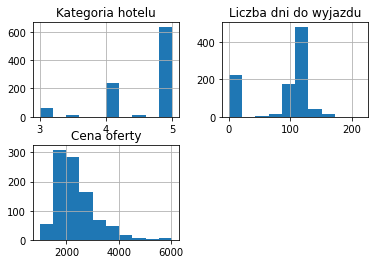

In [149]:
# Rozkład cech:
dane_ML.hist(bins = 10)

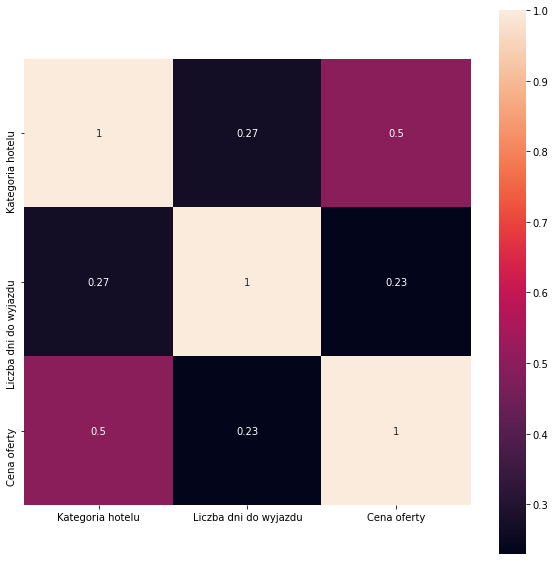

In [150]:
# Sprawdzenie korelacji między zmiennymi:
korelacja = dane_ML.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(korelacja, square = True, annot = True)

Jak widać, między zmiennymi nie ma dużej korelacji. Trudno więc o usuwanie jakiejkolwiek ze względu na to kryterium.

4. Kodowanie zmiennych kategorycznych

Do zakodowania mamy dwie zmienne: 'Region' i 'Rodzaj wyżywienia'. Zakodujemy je za pomocą funkcji get_dummies():

In [151]:
dane_ML = pd.get_dummies(dane_ML, columns = ['Region', 'Rodzaj wyżywienia'], prefix_sep = ': ')
dane_ML.head(10)

,Kategoria hotelu,Liczba dni do wyjazdu,Cena oferty,Region: Riwiera Egejska,Region: Riwiera Turecka,Rodzaj wyżywienia: All Inclusive,Rodzaj wyżywienia: Ultra All Inclusive,Rodzaj wyżywienia: bez wyżywienia,Rodzaj wyżywienia: śniadania,Rodzaj wyżywienia: śniadania i obiadokolacje
0,5.0,2,1725.0,0,1,0,1,0,0,0
1,5.0,108,2135.0,1,0,0,1,0,0,0
2,4.0,97,1971.0,1,0,1,0,0,0,0
3,5.0,128,2214.0,0,1,0,1,0,0,0
4,5.0,117,2363.0,0,1,0,1,0,0,0
5,5.0,117,2751.0,0,1,0,1,0,0,0
6,5.0,118,2235.0,0,1,1,0,0,0,0
7,4.0,85,1953.0,0,1,1,0,0,0,0
8,4.0,15,1943.0,0,1,1,0,0,0,0
9,5.0,0,1777.0,0,1,1,0,0,0,0


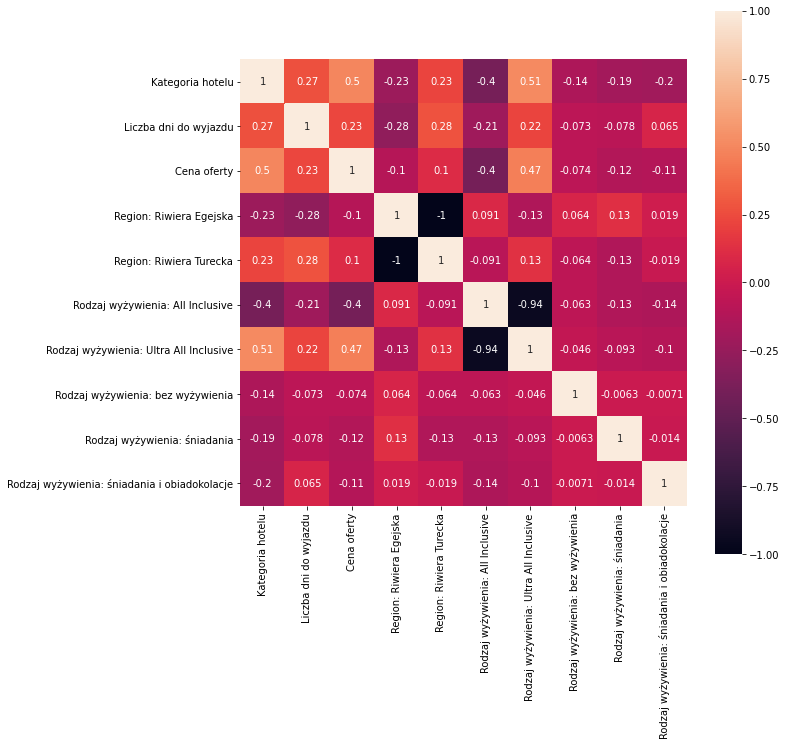

In [152]:
# Ponowne sprawdzenie korelacji między zmiennymi:
korelacja = dane_ML.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(korelacja, square = True, annot = True)

# 3. Tworzenie i zastosowanie modelu uczenia maszynowego

1. Podział danych na zbiory uczący i testowy:

In [153]:
# Tworzenie zbiorów: zmienne objaśniające i zmienna objaśniana:
X = dane_ML.drop(columns = 'Cena oferty')
y = dane_ML['Cena oferty']

# Podział danych na zbiory:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size = 0.2, random_state = 2000)

# Rozmiary utworzonych zbiorów:
print('X_uczący: ', X_train.shape, ', X_testowy: ', X_test.shape, '\n', 'y_uczący: ', y_train.shape, ', y_testowy', y_test.shape)

X_uczący:  (767, 9) , X_testowy:  (192, 9) 
 y_uczący:  (767,) , y_testowy (192,)


2. Standaryzacja zmiennych objaśniających:

In [154]:
# Standaryzujemy zmienne objaśniające zbiorów testowego i uczącego:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

print(X_train_std.shape)
X_train_std

(767, 9)


array([[ 0.64001352,  0.3097605 , -0.50325736, ..., -0.051131  ,
        -0.12062448, -0.11493494],
       [ 0.64001352,  0.53973668, -0.50325736, ..., -0.051131  ,
        -0.12062448, -0.11493494],
       [ 0.64001352, -1.78093205,  1.98705488, ..., -0.051131  ,
        -0.12062448, -0.11493494],
       ...,
       [ 0.64001352,  0.45610897, -0.50325736, ..., -0.051131  ,
        -0.12062448, -0.11493494],
       [ 0.64001352,  0.33066742,  1.98705488, ..., -0.051131  ,
        -0.12062448, -0.11493494],
       [ 0.64001352,  0.60245745, -0.50325736, ..., -0.051131  ,
        -0.12062448, -0.11493494]])

3. Stworzenie i uczenie modelu:

Wykorzystamy i sprawdzimy trzy modele regresji (albowiem, temat predykcji ceny na podstawie parametrów wybitnie wymaga zastosowania modeli regresji):

* Standardowy model regresji liniowej - LinearRegression(),
* Model Ridge(),
* Model Lasso(),
* Model ElasticNet().

Zastosujemy każdy z modeli (na początku, wszystkie, na domyślnych parametrach), dokonamy predykcji i obliczymy wartości MSE i RMSE.

In [155]:
# Tworzenie modeli:
models = {'Standard Linear': linear_model.LinearRegression(),
           'Ridge': linear_model.Ridge(),
           'Lasso': linear_model.Lasso(),
           'Elastic Net': linear_model.ElasticNet()}

# Zastosowanie modeli do predykcji i obliczenia błędu średniokwadratowego:
for key in models:
  reg = models[key]                                       # Wybranie modelu do predykcji
  reg.fit(X_train_std, y_train)                           # Uczenie wybranego modelu

  y_pred = reg.predict(X_test_std)                        # Predykcja na podstawie modelu

  print('Used model: ', models[key])
  MSE = metrics.mean_squared_error(y_test, y_pred)        # Obliczenie błędu średniokwadratowego
  RMSE = np.sqrt(MSE)                                     # Obliczenie pierwiastka błędu średniokwadratowego
  print('MSE = ', round(MSE, 4))
  print('RMSE = ', round(RMSE, 4))
  print('----------------------------------------------------------------------')


Used model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MSE =  2.6188617972368087e+30
RMSE =  1618289775422439.2
----------------------------------------------------------------------
Used model:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MSE =  451735.9267
RMSE =  672.113
----------------------------------------------------------------------
Used model:  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MSE =  451443.0873
RMSE =  671.8951
----------------------------------------------------------------------
Used model:  ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', t

Jak widzimy, najmniej pomylił się model Lasso. Na drugim miejscu jest Ridge. Model ElasticNet również jest ok. ale za to model standardowej regresji liniowej po prostu ssie. Teraz dokonamy walidacji modeli:

4. Wstępna walidacja modeli:

In [156]:
# Znów wykorzystamy te same modele:
models = {'Standard Linear': linear_model.LinearRegression(),
           'Ridge': linear_model.Ridge(),
           'Lasso': linear_model.Lasso(),
           'Elastic Net': linear_model.ElasticNet()}

# Tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej, dla każdego z modeli:
for key in models:

  stand = StandardScaler()                                            # Metoda standaryzacji danych
  model = models[key]                                                 # Wybór metody modelowania
  proces = pipeline.make_pipeline(stand, model)                       # Tworzenie procesu standaryzacji i wykorzystania modelu regresji
  walidacja = model_selection.KFold(n_splits = 10,                    # Zdefiniowanie metody walidacji modelu
                                    shuffle = True,
                                    random_state = 2000)
  
  walidacja_neg_MSE = model_selection.cross_val_score(proces,         # Krzyżowa walidacja modelu ze sprawdzeniem negatywnego MSE
                                                      X_train,
                                                      y_train,
                                                      cv = walidacja,
                                                      scoring = 'neg_mean_squared_error',
                                                      n_jobs = -1)
  
  walidacja_RMSE = np.sqrt(- walidacja_neg_MSE)                       # Obliczenie pierwiastka błędu średniokwadratowego

  # Prezentacja wyników:
  print('model: ', model)
  print(f'Średnia wartość RMSE dla tego modelu = {walidacja_RMSE.mean()}')
  print(f'Mediana RMSE dla tego modelu = {np.median(walidacja_RMSE)}')
  print(f'Odchylenie standardowe RMSE dla tego modelu = {walidacja_RMSE.std()}')
  print('-------------------------------------------------------------------------------------------')

model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Średnia wartość RMSE dla tego modelu = 620.2543068872707
Mediana RMSE dla tego modelu = 629.3745057037474
Odchylenie standardowe RMSE dla tego modelu = 88.30494499104478
-------------------------------------------------------------------------------------------
model:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Średnia wartość RMSE dla tego modelu = 620.0459917840224
Mediana RMSE dla tego modelu = 628.6716650453513
Odchylenie standardowe RMSE dla tego modelu = 87.95761353445518
-------------------------------------------------------------------------------------------
model:  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Średnia wartość RMSE dla tego modelu = 620

Po dogłębnej analizie okazało się, że jednak znów zwyciężył model Lasso, który uzyskał najmniejszą średnią wartość RMSE (620,03 zł/osoba). Ale wciąż ta wartość pomyłek nie mieści się w zakładanym zakresie tolerancji (zakładaliśmy 500 zł/os.) W następnym kroku spróbujemy zoptymalizować parametry modelu Lasso tak, aby był on jeszcze mniej omylny.

5. Optymalizacja wybranego modelu regresji:

In [157]:
# Model wybrany do dalszej zabawy: Lasso()

In [158]:
# Wyświetlmy parametry modelu, którymi możemy się pobawić:
model = linear_model.Lasso()

from pprint import pprint
pprint(model.get_params())

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


W celu dobrania optymalnych wartości parametrów wykorzystamy funkcję GridSearchCV():

In [159]:
# Zdefiniowanie siatki parametrów do ustawiania:
siatka_parametrów = [{'alpha': [0.0, 0.25, 0.5, 0.75, 1.0],     # Stała wielokrotności wartości L1
                      'max_iter': [10, 100, 1000],              # Maksymalna liczba iteracji
                      'precompute': [True, False],              # ???
                      'selection': ['cyclic', 'random'],        # ???
                      'tol': [0.0001, 0.001, 0.01]}]            # Tolerancja na coś tam

# Zdefiniowanie metody walidacji modelu:
walidacja = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 2000)

# Konfiguracja procesu testowania siatki parametrów
# Funkcja dobierze optymalne wartości parametrów z siatki tak aby zminimalizować wartość MSE:
konfiguracja = pipeline.make_pipeline(StandardScaler(),
                                      model_selection.GridSearchCV(model,
                                                                   siatka_parametrów,
                                                                   cv = walidacja,
                                                                   verbose = 5,
                                                                   scoring = 'neg_mean_squared_error',
                                                                   n_jobs = -1))

# Uczenie modelu ze skonfugurowanymi w wyniku użycia GridSearchCV() parametrami:
konfiguracja.fit(X_train, y_train)

konfig_siatka = konfiguracja.named_steps['gridsearchcv']

# Wyświetl najlepsze parametry modelu:
print('Parametry optymalne dla modelu:')
konfig_siatka.best_params_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s


Parametry optymalne dla modelu:


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    3.7s finished


{'alpha': 0.5,
 'max_iter': 10,
 'precompute': False,
 'selection': 'random',
 'tol': 0.01}

Jeśli już wybraliśmy optymalne parametry, to spróbujmy coś przewidzieć na podstawie tego modelu...

In [160]:
# Model doskonały :-)
best_model = konfig_siatka.best_estimator_

# Predykcja na tym modelu:
y_pred = best_model.predict(X_test_std)

# Wyliczenie metryk:
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

print(f'Wartość MSE dla modelu idealnego = {MSE: 4}')
print(f'Wartość RMSE dla modelu idealnego = {RMSE: 4}')

Wartość MSE dla modelu idealnego =  452229.8440115543
Wartość RMSE dla modelu idealnego =  672.4803670082528


Niestety nie udało się spełnić zamierzonego celu. Model myli się bardziej niż chcieliśmy. Tak więc może jest to wina zbyt małej liczby obserwacji, może to kwestia wyboru cech objaśniających a może inne.

In [169]:
# Predykcja na całym zbiorze:

predykcja_cały_zbiór = best_model.predict(stand.fit_transform(X))

dane_ML['Cena przewidziana'] = predykcja_cały_zbiór

# Błąd względny predykcji:
dane_ML['Błąd predykcji'] = (dane_ML['Cena przewidziana'] - dane_ML['Cena oferty']) / dane_ML['Cena oferty']

In [170]:
# Wykres cen przewidzianych przez model:
px.scatter(dane_ML,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena przewidziana',
           color = 'Błąd predykcji',
           title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem błędu predykcji')

In [171]:
# Wykres cen rzeczywistych:
px.scatter(dane_ML,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena oferty',
           color = 'Błąd predykcji',
           title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem błędu predykcji')